# BOB dataset - segmented using Freesurfer

- similar structure to notebook 3a 
- Segmentation done using freesurfer - SynthSeg
- at the end - comparison of FD between both segmentation methods

In [ ]:
import ants
import subprocess
import nibabel as nib
import pandas as pd 
import utils as ut
from natsort import natsort_keygen
import numpy as np
from pathlib import Path
import subprocess
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
import utils as ut
import re
import math
from scipy.stats import pearsonr
from scipy.stats import ttest_rel
import statsmodels.formula.api as smf

## Data  

In [2]:
#example file
t1_scan = '../../Datasets/BOB/sub-116056/ses-3mo/anat/sub-116056_ses-3mo_space-INFANTMNIacpc_T1w.nii.gz'

Checking the data from the file  

In [3]:
im = nib.load(t1_scan)
print(im.header) 

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 16384
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 182 218 182   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  0.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'6.0.4:ddd0a010')
aux_file        : np.bytes_(b'')
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.

In [72]:
csvpath = '../../Datasets/BOB/phenotype/sessions.tsv'
ds_info = pd.read_csv(csvpath, sep ='\t')
ds_info.head()

,participant_id,session_id,age,gestational_age_at_birth,sex
0,sub-116056,ses-3mo,3.6,40.4,Male
1,sub-116845,ses-3mo,3.6,37.7,Female
2,sub-116845,ses-6mo,6.5,37.7,Female
3,sub-176427,ses-5mo,5.0,41.7,Female
4,sub-198202,ses-5mo,5.9,40.1,Male


## Segmentations
Using synthseg tool 2 main options here : with or without cortical parcellation.  
Cortical parcellation means that we segment the upper part of the brain in even more known brain parts, unecessary if we want to use the white/gray matter for FD later.  

In [36]:
# Check and start Docker if necessary
if not ut.is_docker_running():
    print("Docker is not running. Starting it now...")
    ut.start_docker()
else:
    print("Docker is running.")

Docker is running.


Installation was done from [docker]() or [Freesurfer 7.4.1](https://surfer.nmr.mgh.harvard.edu/fswiki/rel7downloads), it can also be *simply* installed [locally](https://github.com/BBillot/SynthSeg) and.  
We run a docker version since we use it for the skullstrip anyways : 

In [8]:
inp = './sample/registered_0.nii.gz' 
# inp = t2_scan
out = './sample/segmented_1.nii.gz'
csv_path, qc_path = './sample/vol_0.csv', './sample/qc_0.csv' # come with builtin recap of volumes and quality check

# parcellation
# cmd_parc = f'./synthseg.py --i {inp} --o {out} --vol {csv_path} --qc {qc_path} --parc --robust --cpu --threads 8'
# no parcellation
cmd_no_parc = f'./synthseg.py --i {inp} --o {out} --vol {csv_path} --qc {qc_path} --robust --cpu --threads 8'

seg_process = subprocess.run([cmd_no_parc], shell = True)

Test run

In [ ]:
# 1) Utility to convert a Windows Path to the /c/... POSIX style Docker wants
def win2posix(raw_path: str) -> str:
    p = Path(raw_path).resolve()
    drive = p.drive.rstrip(':').lower()            # "c"
    tail  = p.as_posix()[len(p.drive):]            # "/Users/…"
    return f"/{drive}{tail}"                       # "/c/Users/…"

# 2) Define your local sample directory
local_sample = Path.cwd() / "sample"
host_dir = win2posix(str(local_sample))

# DEBUG: ensure it prints e.g. "/c/Users/natha/.../sample"
print("Mounting host_dir =", host_dir)

# 3) Build the docker command
docker_cmd = [
    "docker", "run", "--rm",
    "-v", f"{host_dir}:/data",       # mount your sample folder at /data
    "cookpa/synthseg:conda-0.1",     # the Docker image
    "--i",  "/data/registered_0.nii.gz",
    "--o",  "/data/segmented_1new2.nii.gz",
    "--vol","/data/vol_0new2.csv",
    "--qc", "/data/qc_0new2.csv",
    "--parc",
    "--robust",
    "--cpu",
    "--threads", "8",
]

# 4) Run and capture
result = subprocess.run(
    docker_cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)

print("RETURN CODE:", result.returncode)
print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)

if result.returncode != 0:
    raise RuntimeError(f"synthseg (docker) failed (exit {result.returncode})")


Mounting host_dir = /c/Users/natha/Documents/HSLU_local/master_thesis/mri_fractal/data_pipeline/sample
RETURN CODE: 0
STDOUT:
 
SynthSeg-robust 2.0

using CPU, hiding all CUDA_VISIBLE_DEVICES
using 8 threads
predicting 1/1

segmentation  saved in:    /data/segmented_1new2.nii.gz
volumes saved in:          /data/vol_0new2.csv
QC scores saved in:        /data/qc_0new2.csv

If you use the new robust version of SynthSeg in a publication, please cite:
Robust Segmentation of Brain MRI in the Wild with Hierarchical CNNs and no Retraining
B. Billot, M. Collin, S.E. Arnold, S. Das, J.E. Iglesias

STDERR:
 2025-04-24 13:46:37.070894: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-04-24 13:46:37.070976: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-24 13:46:37.071009: I tensorflow/stream_exe

In [12]:
img = nib.load('sample/segmented_1.nii.gz')
array = img.get_fdata()
array.shape # note that the segmentation is smaller in volume

(101, 137, 109)

In [14]:
# Freesurfer label mapping
index_to_label = {}
with open('FreeSurferColorLUT.txt', 'r') as file:
    for line in file:
        # comments or empty
        if line.startswith('#') or not line.strip():
            continue

        parts = line.split()
        index = int(parts[0])
        label_name = ' '.join(parts[1:-4])
        index_to_label[index] = label_name

In [15]:
present_labels = np.unique(array)
# len(present_labels)
print("Detected labels :")
for i, lbl in enumerate(present_labels):
    label_name = index_to_label.get(lbl, 'Unknown')
    print(f"{int(lbl)}: {label_name}")
print(f"Detected {len(present_labels)} labels")

Detected labels :
0: Unknown
2: Left-Cerebral-White-Matter
3: Left-Cerebral-Cortex
4: Left-Lateral-Ventricle
5: Left-Inf-Lat-Vent
7: Left-Cerebellum-White-Matter
8: Left-Cerebellum-Cortex
10: Left-Thalamus
11: Left-Caudate
12: Left-Putamen
13: Left-Pallidum
14: 3rd-Ventricle
15: 4th-Ventricle
16: Brain-Stem
17: Left-Hippocampus
18: Left-Amygdala
24: CSF
26: Left-Accumbens-area
28: Left-VentralDC
41: Right-Cerebral-White-Matter
42: Right-Cerebral-Cortex
43: Right-Lateral-Ventricle
44: Right-Inf-Lat-Vent
46: Right-Cerebellum-White-Matter
47: Right-Cerebellum-Cortex
49: Right-Thalamus
50: Right-Caudate
51: Right-Putamen
52: Right-Pallidum
53: Right-Hippocampus
54: Right-Amygdala
58: Right-Accumbens-area
60: Right-VentralDC
Detected 33 labels


## Loop for all images

Create txt files with all images.

In [ ]:
def win2posix(raw_path: str) -> str:
    """Convert a Windows absolute path (C:\…) into WSL/Docker-friendly /c/... form."""
    p     = Path(raw_path).resolve()
    drive = p.drive.rstrip(':').lower()       # "c"
    tail  = p.as_posix()[len(p.drive):]       # "/Users/…/scan.nii.gz"
    return f"/{drive}{tail}"                  # "/c/Users/…/scan.nii.gz"

bob_win    = Path(r"../../Datasets/BOB")
seg_win    = Path(r"../../Datasets/BOB_segmented")

# make directory for the output
seg_win.mkdir(parents=True, exist_ok=True)

inputs, outputs = [], []

# Collect scans & plan matches
for img in bob_win.rglob("*.nii*"):
    rel_path = img.relative_to(bob_win)            
    out_img  = seg_win / rel_path                  

    # ensure the parent folder for this output exists
    out_img.parent.mkdir(parents=True, exist_ok=True)

    inputs.append(win2posix(str(img)))
    outputs.append(win2posix(str(out_img)))

# Write the two list files
in_list  = bob_win / "synthseg_inputs.txt"
out_list = bob_win / "synthseg_outputs.txt"

in_list.write_text("\n".join(inputs))
out_list.write_text("\n".join(outputs))

print(f"Wrote {len(inputs)} lines to:")
print("  ", in_list)
print("  ", out_list)


Wrote 213 lines to:
   ..\..\Datasets\BOB\synthseg_inputs.txt
   ..\..\Datasets\BOB\synthseg_outputs.txt


Now create txt files, for input and output, only containing the T1w images.

In [ ]:
# Paths for the filtered T1-only lists
root        = Path("../../Datasets/BOB")
in_T1_list  = root / "synthseg_inputs_T1.txt"
out_T1_list = root / "synthseg_outputs_T1.txt"

with in_list.open() as fi, out_list.open() as fo:
    inputs  = [line.strip() for line in fi]
    outputs = [line.strip() for line in fo]

# Filter pairs where the basename has “T1”
filtered_in, filtered_out = [], []
for inp, outp in zip(inputs, outputs):
    if Path(inp).name.lower().find("t1") != -1:
        filtered_in.append(inp)
        filtered_out.append(outp)

# Write the new T1-only lists
in_T1_list.write_text("\n".join(filtered_in) + "\n")
out_T1_list.write_text("\n".join(filtered_out) + "\n")

print(f"Wrote {len(filtered_in)} T1 entries to:")
print("  ", in_T1_list)
print("  ", out_T1_list)

Wrote 71 T1 entries to:
   ..\..\Datasets\BOB\synthseg_inputs_T1.txt
   ..\..\Datasets\BOB\synthseg_outputs_T1.txt


In [5]:
root = Path("../../Datasets/BOB")
for fname in ("synthseg_inputs_T1.txt", "synthseg_outputs_T1.txt"):
    print(f"--- {fname} ---")
    with open(root / fname, 'r') as f:
        for i, line in enumerate(f):
            if i == 5:      # after 5 lines, stop
                break
            print(line.rstrip())
    print()


--- synthseg_inputs_T1.txt ---
/c/Users/natha/Documents/HSLU_local/master_thesis/Datasets/BOB/sub-116056/ses-3mo/anat/sub-116056_ses-3mo_space-INFANTMNIacpc_T1w.nii.gz
/c/Users/natha/Documents/HSLU_local/master_thesis/Datasets/BOB/sub-116845/ses-3mo/anat/sub-116845_ses-3mo_space-INFANTMNIacpc_T1w.nii.gz
/c/Users/natha/Documents/HSLU_local/master_thesis/Datasets/BOB/sub-116845/ses-6mo/anat/sub-116845_ses-6mo_space-INFANTMNIacpc_T1w.nii.gz
/c/Users/natha/Documents/HSLU_local/master_thesis/Datasets/BOB/sub-176427/ses-5mo/anat/sub-176427_ses-5mo_space-INFANTMNIacpc_T1w.nii.gz
/c/Users/natha/Documents/HSLU_local/master_thesis/Datasets/BOB/sub-198202/ses-5mo/anat/sub-198202_ses-5mo_space-INFANTMNIacpc_T1w.nii.gz

--- synthseg_outputs_T1.txt ---
/c/Users/natha/Documents/HSLU_local/master_thesis/Datasets/BOB_segmented/sub-116056/ses-3mo/anat/sub-116056_ses-3mo_space-INFANTMNIacpc_T1w.nii.gz
/c/Users/natha/Documents/HSLU_local/master_thesis/Datasets/BOB_segmented/sub-116845/ses-3mo/anat/sub-116

Create txt files with the paths for volumn and qc.

In [17]:
vol_list    = root / "synthseg_volumes.txt"
qc_list     = root / "synthseg_qc.txt"

# Read your existing inputs & outputs
with in_T1_list.open() as fi, out_T1_list.open() as fo:
    ins  = [l.strip() for l in fi]
    outs = [l.strip() for l in fo]

vols, qcs = [], []
for outp in outs:
    # replace the .nii or .nii.gz extension with _vol.csv / _qc.csv
    if outp.lower().endswith(".nii.gz"):
        base = outp[:-7]    # drop ".nii.gz"
    else:
        base = outp.rsplit(".", 1)[0]
    vols.append(base + "_vol.csv")
    qcs .append(base + "_qc.csv")

# Write them out
vol_list.write_text("\n".join(vols) + "\n")
qc_list.write_text( "\n".join(qcs)  + "\n")

print(f"{len(vols)} volume paths written to: {vol_list}")
print(f"{len(qcs )} QC paths written to: {qc_list }")


71 volume paths written to: ..\..\Datasets\BOB\synthseg_volumes.txt
71 QC paths written to: ..\..\Datasets\BOB\synthseg_qc.txt


In [20]:
# convert Windows to Docker-style POSIX mount
def win2posix(wp):
    p     = Path(wp).resolve()
    drive = p.drive.rstrip(':').lower()
    tail  = p.as_posix()[len(p.drive):]
    return f"/{drive}{tail}"

# convert Docker-style POSIX mount to Windows Path object
def posix2win(pp: str) -> Path:
    comps = pp.lstrip("/").split("/")
    drive = comps[0].upper() + ":" + "\\"
    rest = comps[1:]
    return Path(drive, *rest)

In [39]:
def get_scan_id(pp: str) -> str:
    """
    From any POSIX path like
      /c/.../BOB[_segmented]/sub-116056/ses-3mo/anat/...filename...
    extract the chunk 'sub-116056/ses-3mo/anat'
    so that all three logs collapse to the same key.
    """
    parts = pp.lstrip("/").split("/")
    for i, p in enumerate(parts):
        if p.startswith("sub-") and i+2 < len(parts) and parts[i+2] == "anat":
            return "/".join(parts[i : i+3])
    raise ValueError(f"Can't parse scan ID from {pp!r}")

def load_scan_ids(log_txt: Path) -> set[str]:
    """
    Read each non-blank line from the POSIX-style log file,
    convert to Windows path, check it really exists,
    and then return the set of scan_ids for those that do.
    """
    if not log_txt.exists():
        return set()

    ids = set()
    for ln in log_txt.read_text().splitlines():
        pp = ln.strip()
        if not pp:
            continue
        winp = posix2win(pp)
        if winp.exists():
            ids.add(get_scan_id(pp))
    return ids

win_root  = Path(r"C:\Users\natha\Documents\HSLU_local\master_thesis\Datasets\BOB")
in_list   = win_root / "synthseg_inputs_T1.txt"
out_list  = win_root / "synthseg_outputs_T1.txt"
vol_list  = win_root / "synthseg_volumes.txt"
qc_list   = win_root / "synthseg_qc.txt"

# load the master inputs
inputs = [l.strip() for l in in_list.read_text().splitlines() if l.strip()]

# build the set of scan IDs for each log file
out_ids = load_scan_ids(out_list)
vol_ids = load_scan_ids(vol_list)
qc_ids  = load_scan_ids(qc_list)

fully_done_ids = out_ids & vol_ids & qc_ids
print(f"{len(fully_done_ids)} scans have all 3 outputs.")

pending = [
    pp for pp in inputs
    if get_scan_id(pp) not in fully_done_ids
]
print(f"{len(pending)} scans still need processing.")


37 scans have all 3 outputs.
34 scans still need processing.


In [40]:
pending_ids = { get_scan_id(pp) for pp in pending }

# write pending input txt
pending_inputs = win_root / "synthseg_inputs_T1_pending.txt"
pending_inputs.write_text("\n".join(pending)+"\n")

def filter_by_pending(master_txt: Path, dest_txt: Path):
    """
    Read the master list, filter by pending IDs
    """
    lines = [
        ln.strip() for ln in master_txt.read_text().splitlines()
        if ln.strip() and get_scan_id(ln) in pending_ids
    ]
    dest_txt.write_text("\n".join(lines)+"\n")
    print(f"Wrote {len(lines)} lines to {dest_txt.name}")

# write txts for outputs, volumes, qc
filter_by_pending(out_list, win_root / "synthseg_outputs_T1_pending.txt")
filter_by_pending(vol_list, win_root / "synthseg_volumes_pending.txt")
filter_by_pending(qc_list,  win_root / "synthseg_qc_pending.txt")

Wrote 34 lines to synthseg_outputs_T1_pending.txt
Wrote 34 lines to synthseg_volumes_pending.txt
Wrote 34 lines to synthseg_qc_pending.txt


In [41]:
win_root = Path(r"C:\Users\natha\Documents\HSLU_local\master_thesis\Datasets\BOB")
in_list  = win_root / "synthseg_inputs_T1_pending.txt"
out_list = win_root / "synthseg_outputs_T1_pending.txt"
vol_list = win_root / "synthseg_volumes_pending.txt"
qc_list  = win_root / "synthseg_qc_pending.txt"

posix_root = win2posix(str(win_root.parent)) 
posix_in   = win2posix(str(in_list))
posix_out  = win2posix(str(out_list))
posix_vol    = win2posix(str(vol_list))
posix_qc     = win2posix(str(qc_list))

# Build & run
cmd = [
    "docker", "run", "--rm",
    "-v", f"{posix_root}:{posix_root}",
    "cookpa/synthseg:conda-0.1",
    "--i", posix_in,
    "--o", posix_out,
    "--vol", posix_vol,
    "--qc", posix_qc,
    "--robust", "--cpu", "--threads", "8",
]

print("Running SynthSeg on all listed scans…")
subprocess.run(cmd, check=True)
print("Done.")

Running SynthSeg on all listed scans…
Done.


Delete the "pending" txt files

In [46]:
for pending_file in win_root.glob("synthseg_*_pending.txt"):
    try:
        pending_file.unlink()
        print(f"Deleted {pending_file.name}")
    except Exception as e:
        print(f"Failed to delete {pending_file.name}: {e}")

Deleted synthseg_inputs_T1_pending.txt
Deleted synthseg_outputs_T1_pending.txt
Deleted synthseg_qc_pending.txt
Deleted synthseg_volumes_pending.txt


### Subfolder for all masks

In [44]:
# Freesurfer label mapping
index_to_label = {}
with open('FreeSurferColorLUT.txt', 'r') as file:
    for line in file:
        # comments or empty
        if line.startswith('#') or not line.strip():
            continue

        parts = line.split()
        index = int(parts[0])
        label_name = ' '.join(parts[1:-4])
        index_to_label[index] = label_name

In [45]:
root = Path(r"C:\Users\natha\Documents\HSLU_local\master_thesis\Datasets\BOB")
out_list  = root / "synthseg_outputs_T1.txt"

# Loop through each segmented file
with out_list.open("r") as f:
    for line in f:
        posix_seg = line.strip()
        win_seg   = posix2win(posix_seg)          

        # create a segmentation_outputs folder alongside the .nii.gz
        sess_dir  = win_seg.parent / "segmentation_outputs"
        sess_dir.mkdir(exist_ok=True)

        # load the segmentation volume
        img   = nib.load(str(win_seg))
        data  = img.get_fdata().astype(int)
        labels = np.unique(data)
        labels = labels[labels != 0]              # skip background label 0

        print(f"[{win_seg.stem}] saving masks for labels: {labels}")

        # write one binary mask per label
        for lbl in labels:
            name = index_to_label.get(int(lbl))
            if not name:
                print(f"skipping unknown label {lbl}")
                continue

            mask = (data == lbl).astype(np.uint8)
            mask_img = nib.Nifti1Image(mask, img.affine, img.header)
            mask_fp  = sess_dir / f"{lbl:03d}_{name}.nii.gz"
            nib.save(mask_img, str(mask_fp))
            print(f"wrote {mask_fp.name}")


[sub-116056_ses-3mo_space-INFANTMNIacpc_T1w.nii] saving masks for labels: [ 2  3  4  5  7  8 10 11 12 13 14 15 16 17 18 24 26 28 41 42 43 44 46 47
 49 50 51 52 53 54 58 60]
wrote 002_Left-Cerebral-White-Matter.nii.gz
wrote 003_Left-Cerebral-Cortex.nii.gz
wrote 004_Left-Lateral-Ventricle.nii.gz
wrote 005_Left-Inf-Lat-Vent.nii.gz
wrote 007_Left-Cerebellum-White-Matter.nii.gz
wrote 008_Left-Cerebellum-Cortex.nii.gz
wrote 010_Left-Thalamus.nii.gz
wrote 011_Left-Caudate.nii.gz
wrote 012_Left-Putamen.nii.gz
wrote 013_Left-Pallidum.nii.gz
wrote 014_3rd-Ventricle.nii.gz
wrote 015_4th-Ventricle.nii.gz
wrote 016_Brain-Stem.nii.gz
wrote 017_Left-Hippocampus.nii.gz
wrote 018_Left-Amygdala.nii.gz
wrote 024_CSF.nii.gz
wrote 026_Left-Accumbens-area.nii.gz
wrote 028_Left-VentralDC.nii.gz
wrote 041_Right-Cerebral-White-Matter.nii.gz
wrote 042_Right-Cerebral-Cortex.nii.gz
wrote 043_Right-Lateral-Ventricle.nii.gz
wrote 044_Right-Inf-Lat-Vent.nii.gz
wrote 046_Right-Cerebellum-White-Matter.nii.gz
wrote 047

## Volume

In [ ]:
root      = Path(r"C:\Users\natha\Documents\HSLU_local\master_thesis\Datasets\BOB")
out_list  = root / "synthseg_volumes.txt"

# container for each CSV's data
dfs = []

with out_list.open("r") as f:
    for line in f:
        posix_csv = line.strip()
        if not posix_csv:
            continue

        win_csv = posix2win(posix_csv)
        if not win_csv.exists():
            print(f"Missing file: {win_csv}")
            continue

        df = pd.read_csv(win_csv)

        participant = win_csv.parents[2].name
        session     = win_csv.parents[1].name

        # add two new columns
        df["participant_id"] = participant
        df["session_id"]     = session

        dfs.append(df)

all_volumes = pd.concat(dfs, ignore_index=True)
all_volumes = all_volumes.rename(columns={"Unnamed: 0": "file"})

print(all_volumes.shape)
all_volumes.head()

(71, 36)


,file,total intracranial,left cerebral white matter,left cerebral cortex,left lateral ventricle,left inferior lateral ventricle,left cerebellum white matter,left cerebellum cortex,left thalamus,left caudate,...,right thalamus,right caudate,right putamen,right pallidum,right hippocampus,right amygdala,right accumbens area,right ventral DC,participant_id,session_id
0,sub-116056_ses-3mo_space-INFANTMNIacpc_T1w,926036.25,141239.110,180189.28,3037.668,274.725,4390.364,30670.338,6016.366,2068.422,...,6319.692,2128.169,3460.950,1017.048,2775.387,1195.089,510.229,2725.633,sub-116056,ses-3mo
1,sub-116845_ses-3mo_space-INFANTMNIacpc_T1w,778984.60,106286.310,161087.22,1823.741,264.021,4119.951,30527.242,5473.652,1573.761,...,5890.916,1696.412,3193.395,887.255,2029.808,997.445,461.360,2407.634,sub-116845,ses-3mo
2,sub-116845_ses-6mo_space-INFANTMNIacpc_T1w,943757.25,130040.734,193892.27,2392.474,243.121,5906.129,42539.260,5782.875,2565.644,...,6061.214,2636.436,3870.728,1149.948,2559.490,1140.920,574.605,2603.462,sub-116845,ses-6mo
3,sub-176427_ses-5mo_space-INFANTMNIacpc_T1w,848892.56,115099.060,171554.22,2560.968,312.249,4981.018,35269.484,5411.672,2381.346,...,5544.915,2615.850,3547.382,1061.459,2922.712,928.251,606.501,2523.578,sub-176427,ses-5mo
4,sub-198202_ses-5mo_space-INFANTMNIacpc_T1w,917995.00,126531.180,203690.22,2136.852,356.124,5091.768,36922.227,6477.319,2813.357,...,6699.940,3112.476,4245.694,1513.529,3078.059,1145.690,745.202,2705.744,sub-198202,ses-5mo


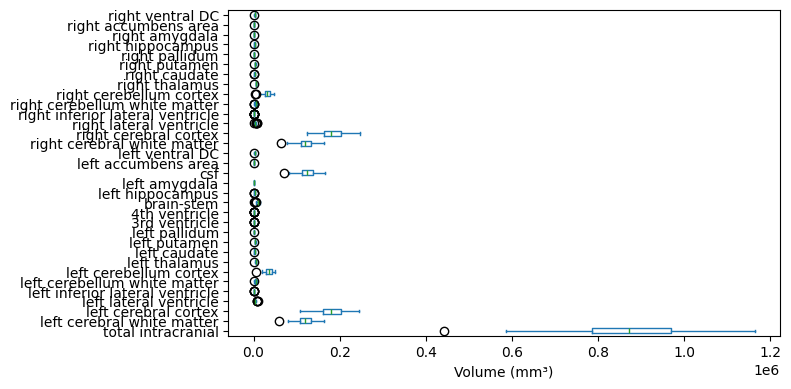

In [71]:
fig, ax = plt.subplots(figsize=(8, 4))
all_volumes.plot.box(vert=False, ax=ax)
ax.set_xlabel('Volume (mm³)')
plt.tight_layout()
plt.show()

C:\Users\natha\AppData\Local\Temp\ipykernel_5668\960924618.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


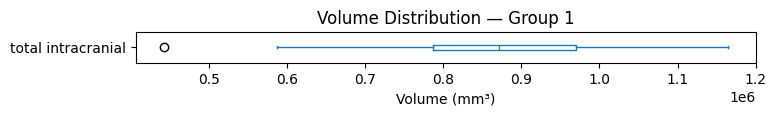

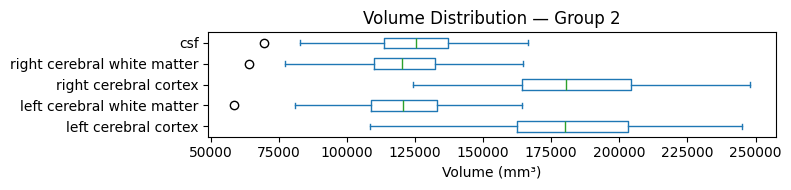

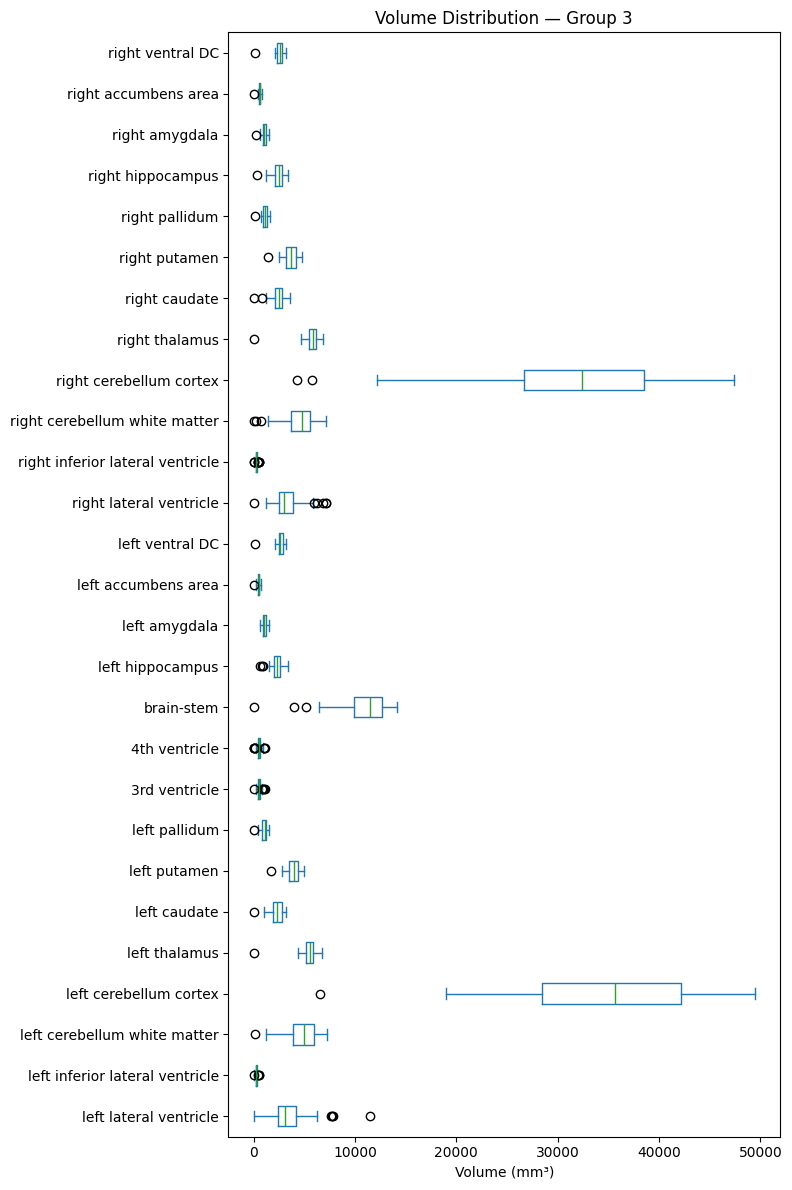

In [70]:
group1 = [
    'total intracranial'
]

group2 = [
    'left cerebral cortex',
    'left cerebral white matter',
    'right cerebral cortex',
    'right cerebral white matter',
    'csf'
]

all_cols = list(all_volumes.columns)
group3 = [col for col in all_cols if col not in group1 + group2]

groups = [group1, group2, group3]

for idx, cols in enumerate(groups, 1):
    fig, ax = plt.subplots(figsize=(8, len(cols)*0.4))
    all_volumes[cols].plot.box(vert=False, ax=ax)
    ax.set_xlabel('Volume (mm³)')
    ax.set_title(f'Volume Distribution — Group {idx}')
    plt.tight_layout()
    plt.show()

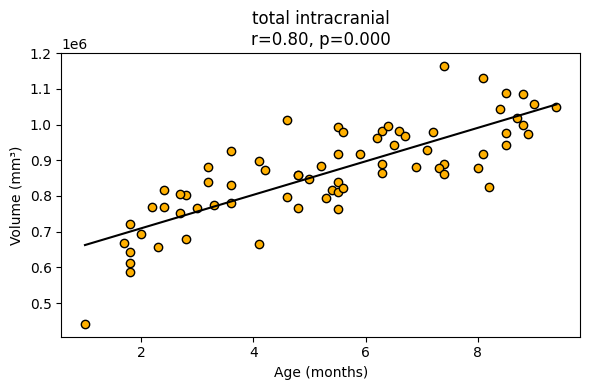

In [74]:
df_vol_merged = all_volumes.merge(
    ds_info,
    on=['participant_id', 'session_id'],
    how='left'
)

vols = df_vol_merged['total intracranial'].values
ages = df_vol_merged['age'].values

# linear fit + stats
slope, intercept = np.polyfit(ages, vols, 1)
x_line = np.linspace(ages.min(), ages.max(), 100)
y_line = slope * x_line + intercept
r_val, p_val = pearsonr(ages, vols)

plt.figure(figsize=(6,4))
plt.scatter(ages, vols, c='#FFB000', edgecolor='k')
plt.plot(x_line, y_line, color='black')
plt.xlabel("Age (months)")
plt.ylabel("Volume (mm³)")
plt.title(f"total intracranial\nr={r_val:.2f}, p={p_val:.3f}")
plt.tight_layout()
plt.show()

## Quality Control

SynthSeg incorporates automatic quality control (QC) scores to assess the accuracy of segmented brain regions. These scores are generated by assessing features of the segmentation against the predicted values from the ’regressor R’ of the SynthSeg model, providing a numerical indication of segmentation quality.

0.65 threshold suggested: https://www.pnas.org/doi/full/10.1073/pnas.2216399120 (original paper)

thresholds anywhere in the 0.55–0.75 range: https://arxiv.org/html/2406.17423v1

In [49]:
root      = Path(r"C:\Users\natha\Documents\HSLU_local\master_thesis\Datasets\BOB")
out_list  = root / "synthseg_qc.txt"

# container for each CSV's data
dfs = []

with out_list.open("r") as f:
    for line in f:
        posix_csv = line.strip()
        if not posix_csv:
            continue

        win_csv = posix2win(posix_csv)
        if not win_csv.exists():
            print(f"Missing file: {win_csv}")
            continue

        df = pd.read_csv(win_csv)

        participant = win_csv.parents[2].name
        session     = win_csv.parents[1].name

        # add two new columns
        df["participant_id"] = participant
        df["session_id"]     = session

        dfs.append(df)

all_qcs = pd.concat(dfs, ignore_index=True)
all_qcs = all_qcs.rename(columns={"Unnamed: 0": "file"})

print(all_qcs.shape)
all_qcs.head()

(71, 11)


,file,general white matter,general grey matter,general csf,cerebellum,brainstem,thalamus,putamen+pallidum,hippocampus+amygdala,participant_id,session_id
0,sub-116056_ses-3mo_space-INFANTMNIacpc_T1w,0.7848,0.6871,0.6814,0.7820,0.8224,0.8298,0.8550,0.8067,sub-116056,ses-3mo
1,sub-116845_ses-3mo_space-INFANTMNIacpc_T1w,0.7283,0.6600,0.6524,0.7903,0.8070,0.7834,0.8254,0.7593,sub-116845,ses-3mo
2,sub-116845_ses-6mo_space-INFANTMNIacpc_T1w,0.7642,0.7116,0.6693,0.8665,0.8514,0.8117,0.8855,0.7980,sub-116845,ses-6mo
3,sub-176427_ses-5mo_space-INFANTMNIacpc_T1w,0.7604,0.6828,0.6871,0.8372,0.8494,0.8036,0.8595,0.8031,sub-176427,ses-5mo
4,sub-198202_ses-5mo_space-INFANTMNIacpc_T1w,0.7463,0.6741,0.6732,0.8273,0.8272,0.8107,0.8657,0.7894,sub-198202,ses-5mo


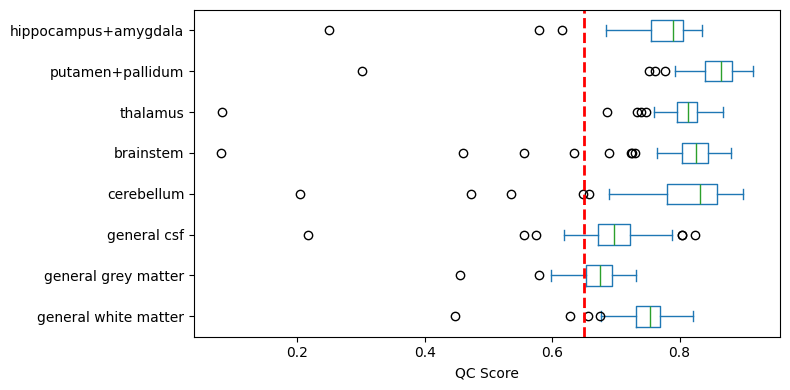

In [63]:
fig, ax = plt.subplots(figsize=(8, 4))
all_qcs.plot.box(vert=False, ax=ax)
ax.axvline(
    x=0.65, color='red', linestyle='--', lw=2, label='QC treshold'
)
ax.set_xlabel('QC Score')
plt.tight_layout()
plt.show()

Below quality treshhold count per region

In [67]:
cols = all_qcs.columns[1:9]
region_counts = (all_qcs[cols] < 0.65).sum()

region_counts_df = (
    region_counts
    .sort_values(ascending=False)
    .reset_index()
)
region_counts_df.columns = ['region', 'low_qc_file_count']
region_counts_df

,region,low_qc_file_count
0,general grey matter,15
1,general csf,9
2,cerebellum,4
3,brainstem,4
4,hippocampus+amygdala,3
5,general white matter,2
6,thalamus,1
7,putamen+pallidum,1


Below quality treshhold count per file

In [ ]:
counts = (all_qcs[cols] < 0.65).sum(axis=1)
qc_below = pd.DataFrame({'file': all_qcs['file'], 'count': counts})
qc_below = qc_below[qc_below['count'] > 0].sort_values(by='count', ascending=False)
qc_below

,file,count
41,sub-584381_ses-1mo_space-INFANTMNIacpc_T1w,8
29,sub-439083_ses-1mo_space-INFANTMNIacpc_T1w,6
34,sub-470437_ses-1mo_space-INFANTMNIacpc_T1w,5
55,sub-761141_ses-1mo_space-INFANTMNIacpc_T1w,3
42,sub-584381_ses-4mo_space-INFANTMNIacpc_T1w,2
68,sub-981854_ses-1mo_space-INFANTMNIacpc_T1w,2
61,sub-938316_ses-2mo_space-INFANTMNIacpc_T1w,2
6,sub-198549_ses-1mo_space-INFANTMNIacpc_T1w,2
66,sub-981664_ses-2mo_space-INFANTMNIacpc_T1w,2
30,sub-439083_ses-4mo_space-INFANTMNIacpc_T1w,1


## Fractal dimension calculation

In [75]:
data_folder = Path("../../Datasets/BOB_segmented")

fd_results = []

# loop over whole-brain dseg files
for dseg in data_folder.rglob("*T1w.nii.gz"):
    participant = dseg.parents[2].name   
    session     = dseg.parents[1].name   
    print(f"processing {participant} {session}")

    # whole-brain FD
    fd, (mfs, Mfs), _ = ut.fractal_analysis(str(dseg), verbose=False)
    fd_results.append({
        'participant_id': participant,
        'session_id':    session,
        'label':         None,
        'name':          'whole_brain',
        'fd':            fd,
        'min_box_size':  mfs,
        'max_box_size':  Mfs
    })

    # per-mask FD
    mask_dir = dseg.parent / "segmentation_outputs"
    if not mask_dir.exists():
        print(f" no masks found for {dseg.stem}, skipping masks")
        continue

    for mask_fp in mask_dir.glob("*.nii.gz"):
        # extract label and name from filename "###_LabelName.nii.gz"
        stem = mask_fp.stem
        lbl_str, name = stem.split("_", 1)
        lbl = int(lbl_str)

        fd, (mfs, Mfs), _ = ut.fractal_analysis(str(mask_fp), verbose=False)
        fd_results.append({
            'participant_id': participant,
            'session_id':    session,
            'label':         lbl,
            'name':          name,
            'fd':            fd,
            'min_box_size':  mfs,
            'max_box_size':  Mfs
        })

processing sub-116056 ses-3mo
FD automatically selected: 2.8088
FD automatically selected: 2.4882
FD automatically selected: 2.4989
FD automatically selected: 1.4089
FD automatically selected: 1.1902
FD automatically selected: 2.0791
FD automatically selected: 2.4744
FD automatically selected: 2.2716
FD automatically selected: 1.9658
FD automatically selected: 2.1095
FD automatically selected: 1.8862
FD automatically selected: 1.7978
FD automatically selected: 1.6291
FD automatically selected: 2.302
FD automatically selected: 2.0108
FD automatically selected: 1.945
FD automatically selected: 2.1786
FD automatically selected: 1.686
FD automatically selected: 2.0579
FD automatically selected: 2.4827
FD automatically selected: 2.4962
FD automatically selected: 1.9226
FD automatically selected: 1.177
FD automatically selected: 2.0826
FD automatically selected: 2.4637
FD automatically selected: 2.2835
FD automatically selected: 1.9732
FD automatically selected: 2.1207
FD automatically selec

In [76]:
df_fd = pd.DataFrame(fd_results)

# reorder columns
df_fd = df_fd[
    ['participant_id','session_id','label','name','fd','min_box_size','max_box_size']
]

df_fd_merged = df_fd.merge(
    ds_info,
    on=['participant_id', 'session_id'],
    how='left'
)

# remove any trailing ".nii"
df_fd_merged['name'] = (
    df_fd_merged['name']
      .str.replace(".nii", "")
)

df_fd_merged.head()

,participant_id,session_id,label,name,fd,min_box_size,max_box_size,age,gestational_age_at_birth,sex
0,sub-116056,ses-3mo,NaN,whole_brain,2.8088,1.0,16.0,3.6,40.4,Male
1,sub-116056,ses-3mo,2.0,Left-Cerebral-White-Matter,2.4882,1.0,16.0,3.6,40.4,Male
2,sub-116056,ses-3mo,3.0,Left-Cerebral-Cortex,2.4989,1.0,16.0,3.6,40.4,Male
3,sub-116056,ses-3mo,4.0,Left-Lateral-Ventricle,1.4089,4.0,64.0,3.6,40.4,Male
4,sub-116056,ses-3mo,5.0,Left-Inf-Lat-Vent,1.1902,2.0,32.0,3.6,40.4,Male


In [77]:
df_fd_merged.to_csv('BOB_fd_results_freesurfer-seg.csv', index=False)

### EDA

In [78]:
n_missing = df_fd_merged['fd'].isna().sum()
print(f"Total missing FD values: {n_missing}")

Total missing FD values: 0


In [79]:
counts = df_fd_merged['name'].value_counts().reset_index()
counts.columns = ['name', 'count']
counts

,name,count
0,whole_brain,71
1,Left-Cerebral-White-Matter,71
2,Left-Cerebral-Cortex,71
3,Left-Inf-Lat-Vent,71
4,Left-Cerebellum-White-Matter,71
5,Left-Caudate,71
6,Left-Cerebellum-Cortex,71
7,Left-Pallidum,71
8,Left-Putamen,71
9,Left-Amygdala,71


### sorted FD plots

In [ ]:
df_fd_merged = pd.read_csv('BOB_fd_results_freesurfer-seg.csv')

In [80]:
def assign_color(label_name):
    if 'Left' in label_name:
        return '#648FFF'
    elif 'Right' in label_name:
        return '#DC267F'
    elif 'whole_brain' in label_name:
        return '#FFB000'
    else:
        return 'grey'

In [81]:
# Determine sort order by median FD descending
region_order = (
    df_fd_merged.groupby('name')['fd']
      .median()
      .sort_values(ascending=False)
      .index
      .tolist()
)

colors = [assign_color(r) for r in region_order]

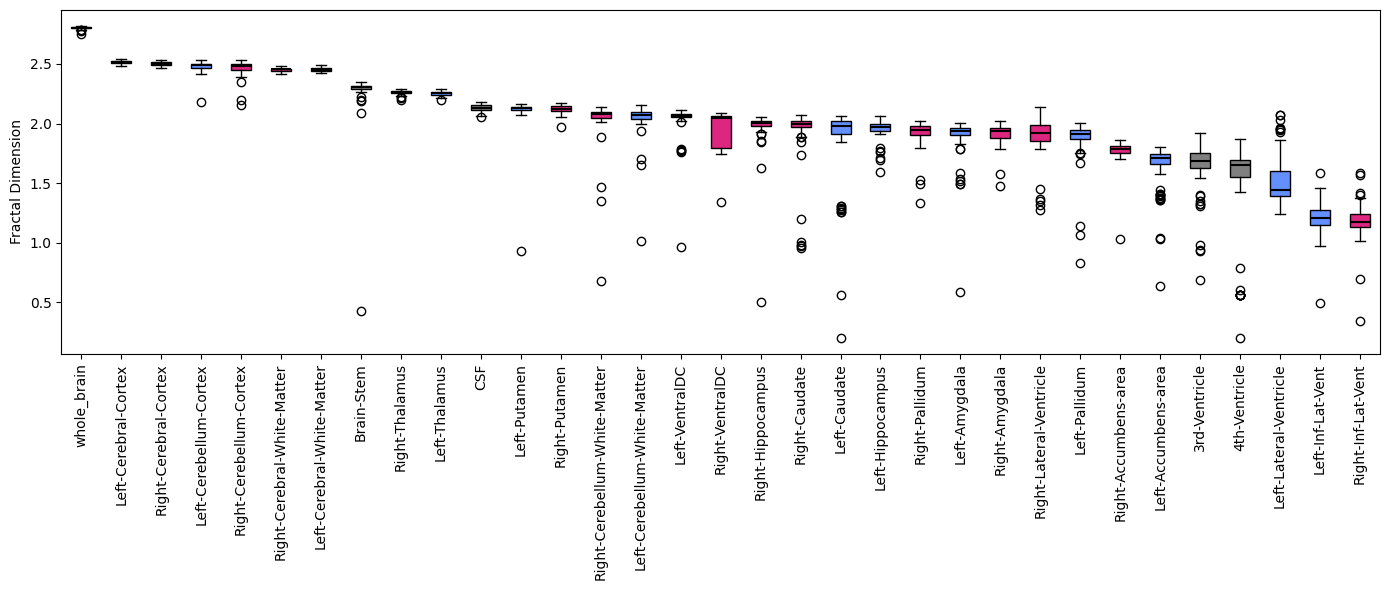

In [82]:
# Prepare data and colors
data_to_plot = [df_fd_merged[df_fd_merged['name'] == r]['fd'] for r in region_order]

plt.figure(figsize=(14, 6))
bp = plt.boxplot(data_to_plot,
                 tick_labels=region_order,
                 patch_artist=True,
                 showfliers=True,
                 medianprops=dict(color='black', linewidth=1.5))

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(rotation=90)
plt.ylabel("Fractal Dimension")
plt.tight_layout()
plt.show()

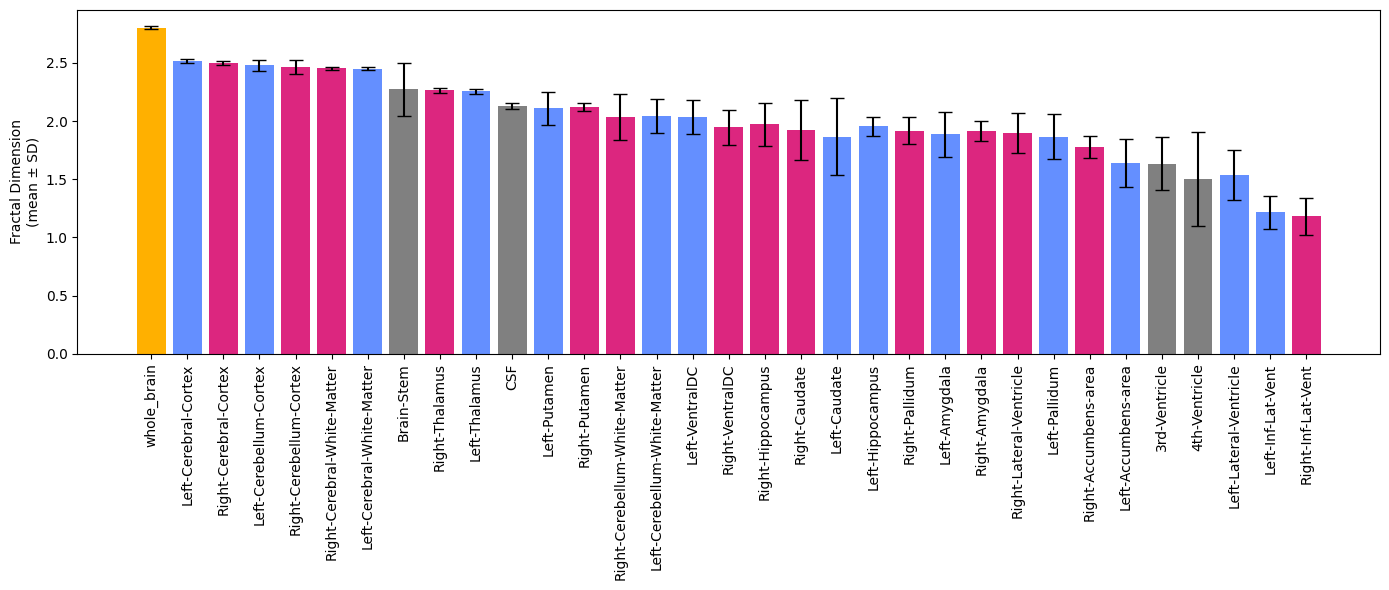

In [83]:
means = []
stds  = []
for r in region_order:
    vals = df_fd_merged.loc[df_fd_merged['name'] == r, 'fd']
    means.append(vals.mean())
    stds.append(vals.std())

x = np.arange(len(region_order))
plt.figure(figsize=(14, 6))
bars = plt.bar(x, means,
               yerr=stds,
               capsize=5,
               color=colors)
plt.xticks(x, region_order, rotation=90)
plt.ylabel("Fractal Dimension\n(mean ± SD)")
plt.tight_layout()
plt.show()

### side comparison

In [84]:
# Helper for Cohen's d (paired)
def cohen_d_paired(x, y):
    diff = x - y
    return diff.mean() / diff.std(ddof=1)

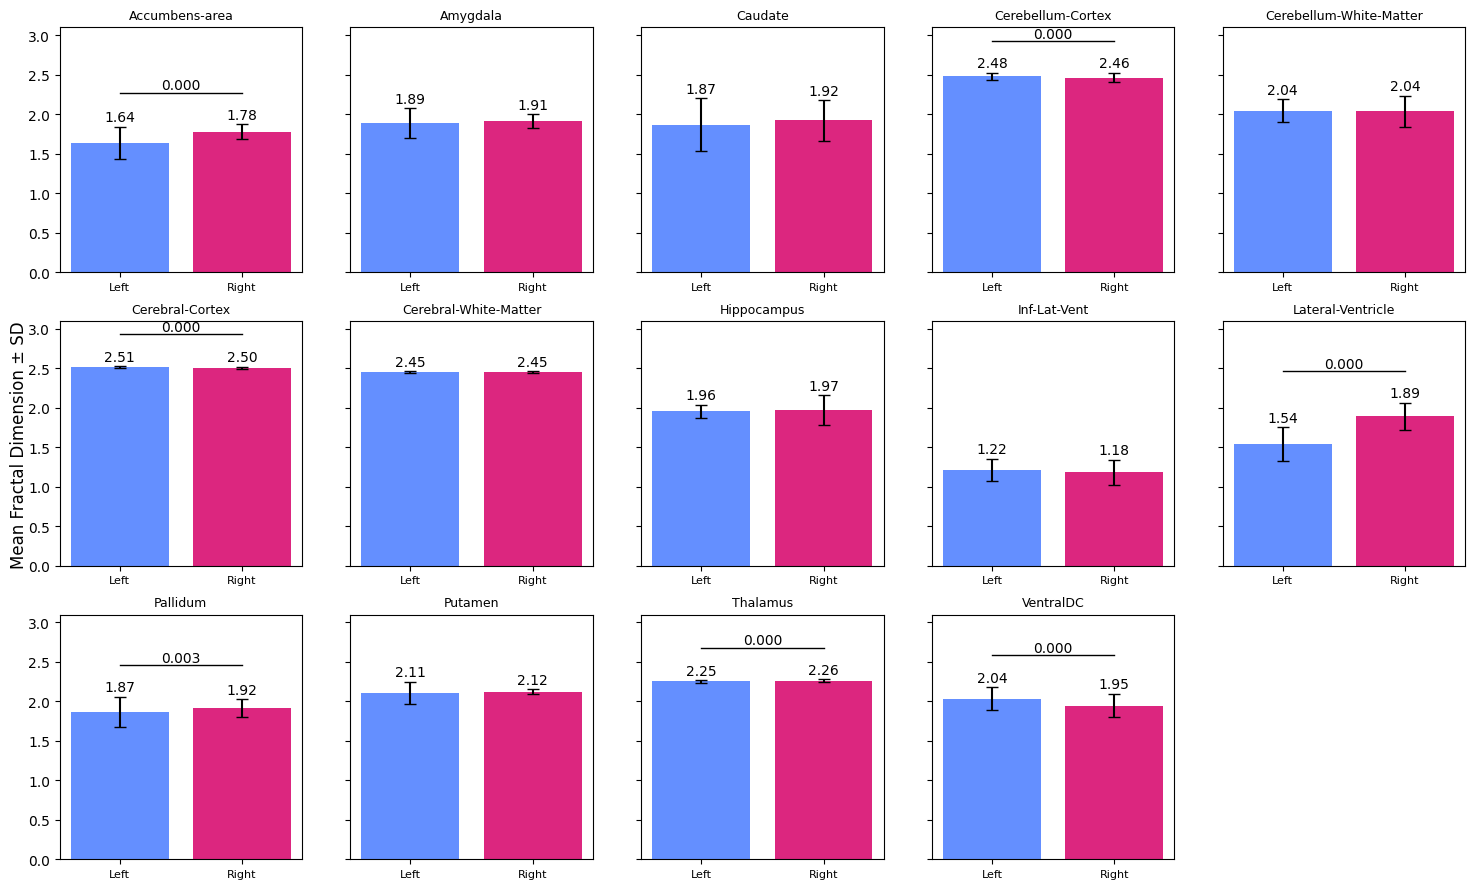

,name,FD (Left),FD (Right),FD (diff),n,p-val,d
0,Accumbens-area,1.64 ± 0.20,1.78 ± 0.10,-0.14 ± 0.17,71,0.000,-0.82
1,Amygdala,1.89 ± 0.19,1.91 ± 0.09,-0.03 ± 0.19,71,0.221,-0.15
2,Caudate,1.89 ± 0.27,1.92 ± 0.26,-0.03 ± 0.34,70,0.442,-0.09
3,Cerebellum-Cortex,2.48 ± 0.04,2.46 ± 0.06,0.02 ± 0.03,71,0.000,0.50
4,Cerebellum-White-Matter,2.04 ± 0.14,2.04 ± 0.20,0.01 ± 0.09,71,0.469,0.09
5,Cerebral-Cortex,2.51 ± 0.01,2.50 ± 0.02,0.01 ± 0.01,71,0.000,1.25
6,Cerebral-White-Matter,2.45 ± 0.01,2.45 ± 0.01,-0.00 ± 0.01,71,0.188,-0.16
7,Hippocampus,1.96 ± 0.08,1.97 ± 0.19,-0.02 ± 0.18,71,0.456,-0.09
8,Inf-Lat-Vent,1.22 ± 0.14,1.18 ± 0.16,0.03 ± 0.15,71,0.066,0.22
9,Lateral-Ventricle,1.54 ± 0.22,1.89 ± 0.17,-0.36 ± 0.26,70,0.000,-1.35


In [85]:
# Copy and clean
df = df_fd_merged.copy()
df['name'] = df['name'].str.replace(r'\.nii(\.gz)?$', '', regex=True)
df['base_name'] = df['name'].apply(lambda x: re.sub(r'^(Left-|Right-)', '', x))
df['side'] = df['name'].apply(lambda x: 'Left' if x.startswith('Left-') else 'Right')

# Identify true pairs
side_counts = df.groupby('base_name')['side'].nunique()
paired_bases = side_counts[side_counts == 2].index.tolist()
df_paired = df[df['base_name'].isin(paired_bases)]

# Compute statistics table
stats_list = []
for base in paired_bases:
    sub = df_paired[df_paired['base_name'] == base]
    pt = sub.pivot_table(index=['participant_id','session_id'],
                         columns='side', values='fd').dropna()
    left = pt['Left']
    right = pt['Right']
    diff = left - right

    mean_diff = diff.mean()
    sd_diff   = diff.std(ddof=1)
    t_stat, p_val = ttest_rel(left, right)
    d_val = cohen_d_paired(left, right)
    
    stats_list.append({
        'name': base,
        'FD (Left)': f"{left.mean():.2f} ± {left.std(ddof=1):.2f}",
        'FD (Right)': f"{right.mean():.2f} ± {right.std(ddof=1):.2f}",
        'FD (diff)': f"{mean_diff:.2f} ± {sd_diff:.2f}",
        'n': len(diff),
        'p-val': f"{p_val:.3f}",
        'd': f"{d_val:.2f}"
    })

df_stats = pd.DataFrame(stats_list)

# Bar plot of mean ± SD with significance stars
# First, compute mean and sd per side
agg = df_paired.groupby(['base_name','side'])['fd'] \
               .agg(mean='mean', sd='std') \
               .reset_index()

n_pairs = len(paired_bases)
ncols   = 5
nrows   = math.ceil(n_pairs / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3), sharey=True)
axes = axes.flatten()

for ax, base in zip(axes, paired_bases):
    sub = agg[agg['base_name'] == base].set_index('side').loc[['Left','Right']].reset_index()
    x = np.arange(2)
    means = sub['mean'].values
    stds  = sub['sd'].values
    full_names = sub['side'] + '-' + base
    colors = [assign_color(fn) for fn in full_names]
    
    # Plot bars
    ax.bar(x, means, yerr=stds, capsize=4, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(sub['side'], fontsize=8)
    ax.set_title(base, fontsize=9)
    
    # Annotate mean values
    for xi, m, sd in zip(x, means, stds):
        ax.text(xi, m + sd + 0.03, f"{m:.2f}", ha='center', va='bottom', fontsize=10)
    
    # Significance star
    row = df_stats[df_stats['name'] == base].iloc[0]
    p = float(row['p-val'])

    if p < 0.05:
        # coordinates
        y0 = max(means + stds) + 0.4           # base height of line
        # draw horizontal line 
        ax.plot([x[0], x[1]], [y0, y0], color='black', linewidth=1)
        # add the star centered
        ax.text((x[0]+x[1])/2, y0 + 0.005, f"{p:.3f}",
                ha='center', va='bottom', fontsize=10)

# Turn off extras
for ax in axes[n_pairs:]:
    ax.axis('off')

fig.supylabel("Mean Fractal Dimension ± SD")
plt.setp(axes, ylim=(0, 3.1))
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

df_stats


Display only the significant differences, after aplying Bonferroni correction for multiple comparison:

In [86]:
# number of paired tests
n_tests = len(df_stats)
alpha_corr = 0.05 / n_tests

df_stats['p_nominal'] = df_stats['p-val'].astype(float)
df_stats['sign_corr'] = df_stats['p_nominal'] < alpha_corr

print(f"Bonferroni α = {alpha_corr:.4f}")
df_stats.loc[df_stats['sign_corr'], ['name', 'FD (Left)', 'FD (Right)', 'FD (diff)', 'p-val', 'd']]

Bonferroni α = 0.0036


,name,FD (Left),FD (Right),FD (diff),p-val,d
0,Accumbens-area,1.64 ± 0.20,1.78 ± 0.10,-0.14 ± 0.17,0.000,-0.82
3,Cerebellum-Cortex,2.48 ± 0.04,2.46 ± 0.06,0.02 ± 0.03,0.000,0.50
5,Cerebral-Cortex,2.51 ± 0.01,2.50 ± 0.02,0.01 ± 0.01,0.000,1.25
9,Lateral-Ventricle,1.54 ± 0.22,1.89 ± 0.17,-0.36 ± 0.26,0.000,-1.35
10,Pallidum,1.87 ± 0.19,1.92 ± 0.11,-0.05 ± 0.14,0.003,-0.37
12,Thalamus,2.25 ± 0.02,2.26 ± 0.02,-0.01 ± 0.01,0.000,-0.78
13,VentralDC,2.04 ± 0.15,1.95 ± 0.15,0.09 ± 0.14,0.000,0.65


### FD Comparison across segmentations

In [120]:
df_fd_BOB = pd.read_csv('BOB_fd_results.csv')
df_fd_fs_seg = pd.read_csv('BOB_fd_results_freesurfer-seg.csv')

colors_seg = ['#FFC107', '#1E88E5']

In [96]:
len(df_fd_fs_seg['name'].unique())

33

In [94]:
common_names = pd.Series(list(set(df_fd_BOB['name'].unique()) & set(df_fd_fs_seg['name'].unique())))
print(f"Common names: {len(common_names)}")
print(common_names)

Common names: 32
0                      Left-Caudate
1                     Right-Caudate
2                    Right-Amygdala
3                        Brain-Stem
4                     Left-Pallidum
5                     Left-Amygdala
6                               CSF
7                    Right-Pallidum
8           Right-Cerebellum-Cortex
9                Right-Inf-Lat-Vent
10    Right-Cerebellum-White-Matter
11             Left-Cerebral-Cortex
12      Right-Cerebral-White-Matter
13             Right-Accumbens-area
14           Left-Lateral-Ventricle
15                      whole_brain
16     Left-Cerebellum-White-Matter
17                     Left-Putamen
18            Right-Cerebral-Cortex
19                    Right-Putamen
20                 Left-Hippocampus
21                  Right-VentralDC
22       Left-Cerebral-White-Matter
23                    4th-Ventricle
24              Left-Accumbens-area
25                Left-Inf-Lat-Vent
26           Left-Cerebellum-Cortex
27         

In [97]:
missing_label = set(df_fd_fs_seg['name'].unique()) - set(df_fd_BOB['name'].unique())
print(missing_label)

{'Left-VentralDC'}


In [98]:
df_fd_BOB_common = df_fd_BOB[df_fd_BOB['name'].isin(common_names)]
df_fd_fs_seg_common = df_fd_fs_seg[df_fd_fs_seg['name'].isin(common_names)]

In [100]:
df_fd_BOB_common.head()

,participant_id,session_id,label,name,fd_BOB,min_box_size,max_box_size,age,gestational_age_at_birth,sex
0,sub-116056,ses-3mo,NaN,whole_brain,2.7598,1.0,16.0,3.6,40.4,Male
1,sub-116056,ses-3mo,2.0,Left-Cerebral-White-Matter,2.4704,1.0,16.0,3.6,40.4,Male
2,sub-116056,ses-3mo,3.0,Left-Cerebral-Cortex,2.4475,1.0,16.0,3.6,40.4,Male
3,sub-116056,ses-3mo,4.0,Left-Lateral-Ventricle,1.5052,4.0,64.0,3.6,40.4,Male
4,sub-116056,ses-3mo,5.0,Left-Inf-Lat-Vent,1.3861,1.0,16.0,3.6,40.4,Male


In [101]:
df_fd_BOB_common = df_fd_BOB_common.rename(columns={'fd': 'fd_BOB'})
df_fd_fs_seg_common = df_fd_fs_seg_common.rename(columns={'fd': 'fd_fs_seg'})

df_merged = pd.merge(
    df_fd_BOB_common[['participant_id', 'session_id', 'name', 'fd_BOB','age','sex']],
    df_fd_fs_seg_common[['participant_id', 'session_id', 'name', 'fd_fs_seg']],
    on=['participant_id', 'session_id', 'name'],
    how='inner'
)
df_merged.head()

,participant_id,session_id,name,fd_BOB,age,sex,fd_fs_seg
0,sub-116056,ses-3mo,whole_brain,2.7598,3.6,Male,2.8088
1,sub-116056,ses-3mo,Left-Cerebral-White-Matter,2.4704,3.6,Male,2.4882
2,sub-116056,ses-3mo,Left-Cerebral-Cortex,2.4475,3.6,Male,2.4989
3,sub-116056,ses-3mo,Left-Lateral-Ventricle,1.5052,3.6,Male,1.4089
4,sub-116056,ses-3mo,Left-Inf-Lat-Vent,1.3861,3.6,Male,1.1902


In [102]:
stats_list = []

for label in common_names:
    sub = df_merged[df_merged['name'] == label]
    if sub.empty:
        continue  # Skip if no data
    
    left = sub['fd_BOB']
    right = sub['fd_fs_seg']
    diff = left - right
    
    mean_diff = diff.mean()
    sd_diff   = diff.std(ddof=1)
    t_stat, p_val = ttest_rel(left, right)

    d_val = cohen_d_paired(left, right)
    
    stats_list.append({
        'name': label,
        'FD (BOB)': f"{left.mean():.2f} ± {left.std(ddof=1):.2f}",
        'FD (fs_seg)': f"{right.mean():.2f} ± {right.std(ddof=1):.2f}",
        'FD (diff)': f"{mean_diff:.2f} ± {sd_diff:.2f}",
        'n': len(diff),
        'p-val': f"{p_val:.3f}",
        'd': f"{d_val:.2f}"
    })

df_stats = pd.DataFrame(stats_list)
df_stats

,name,FD (BOB),FD (fs_seg),FD (diff),n,p-val,d
0,Left-Caudate,2.02 ± 0.04,1.87 ± 0.33,0.15 ± 0.31,71,0.000,0.48
1,Right-Caudate,2.01 ± 0.05,1.92 ± 0.26,0.09 ± 0.24,70,0.004,0.36
2,Right-Amygdala,1.84 ± 0.09,1.91 ± 0.09,-0.08 ± 0.07,71,0.000,-1.10
3,Brain-Stem,2.29 ± 0.02,2.27 ± 0.22,0.02 ± 0.22,71,0.562,0.07
4,Left-Pallidum,1.90 ± 0.17,1.87 ± 0.19,0.03 ± 0.21,71,0.178,0.16
5,Left-Amygdala,1.84 ± 0.15,1.89 ± 0.19,-0.04 ± 0.20,71,0.068,-0.22
6,CSF,1.63 ± 0.34,2.13 ± 0.03,-0.50 ± 0.34,46,0.000,-1.47
7,Right-Pallidum,1.89 ± 0.18,1.92 ± 0.11,-0.03 ± 0.19,71,0.187,-0.16
8,Right-Cerebellum-Cortex,2.44 ± 0.05,2.46 ± 0.06,-0.03 ± 0.04,71,0.000,-0.73
9,Right-Inf-Lat-Vent,1.36 ± 0.16,1.18 ± 0.16,0.18 ± 0.16,71,0.000,1.14


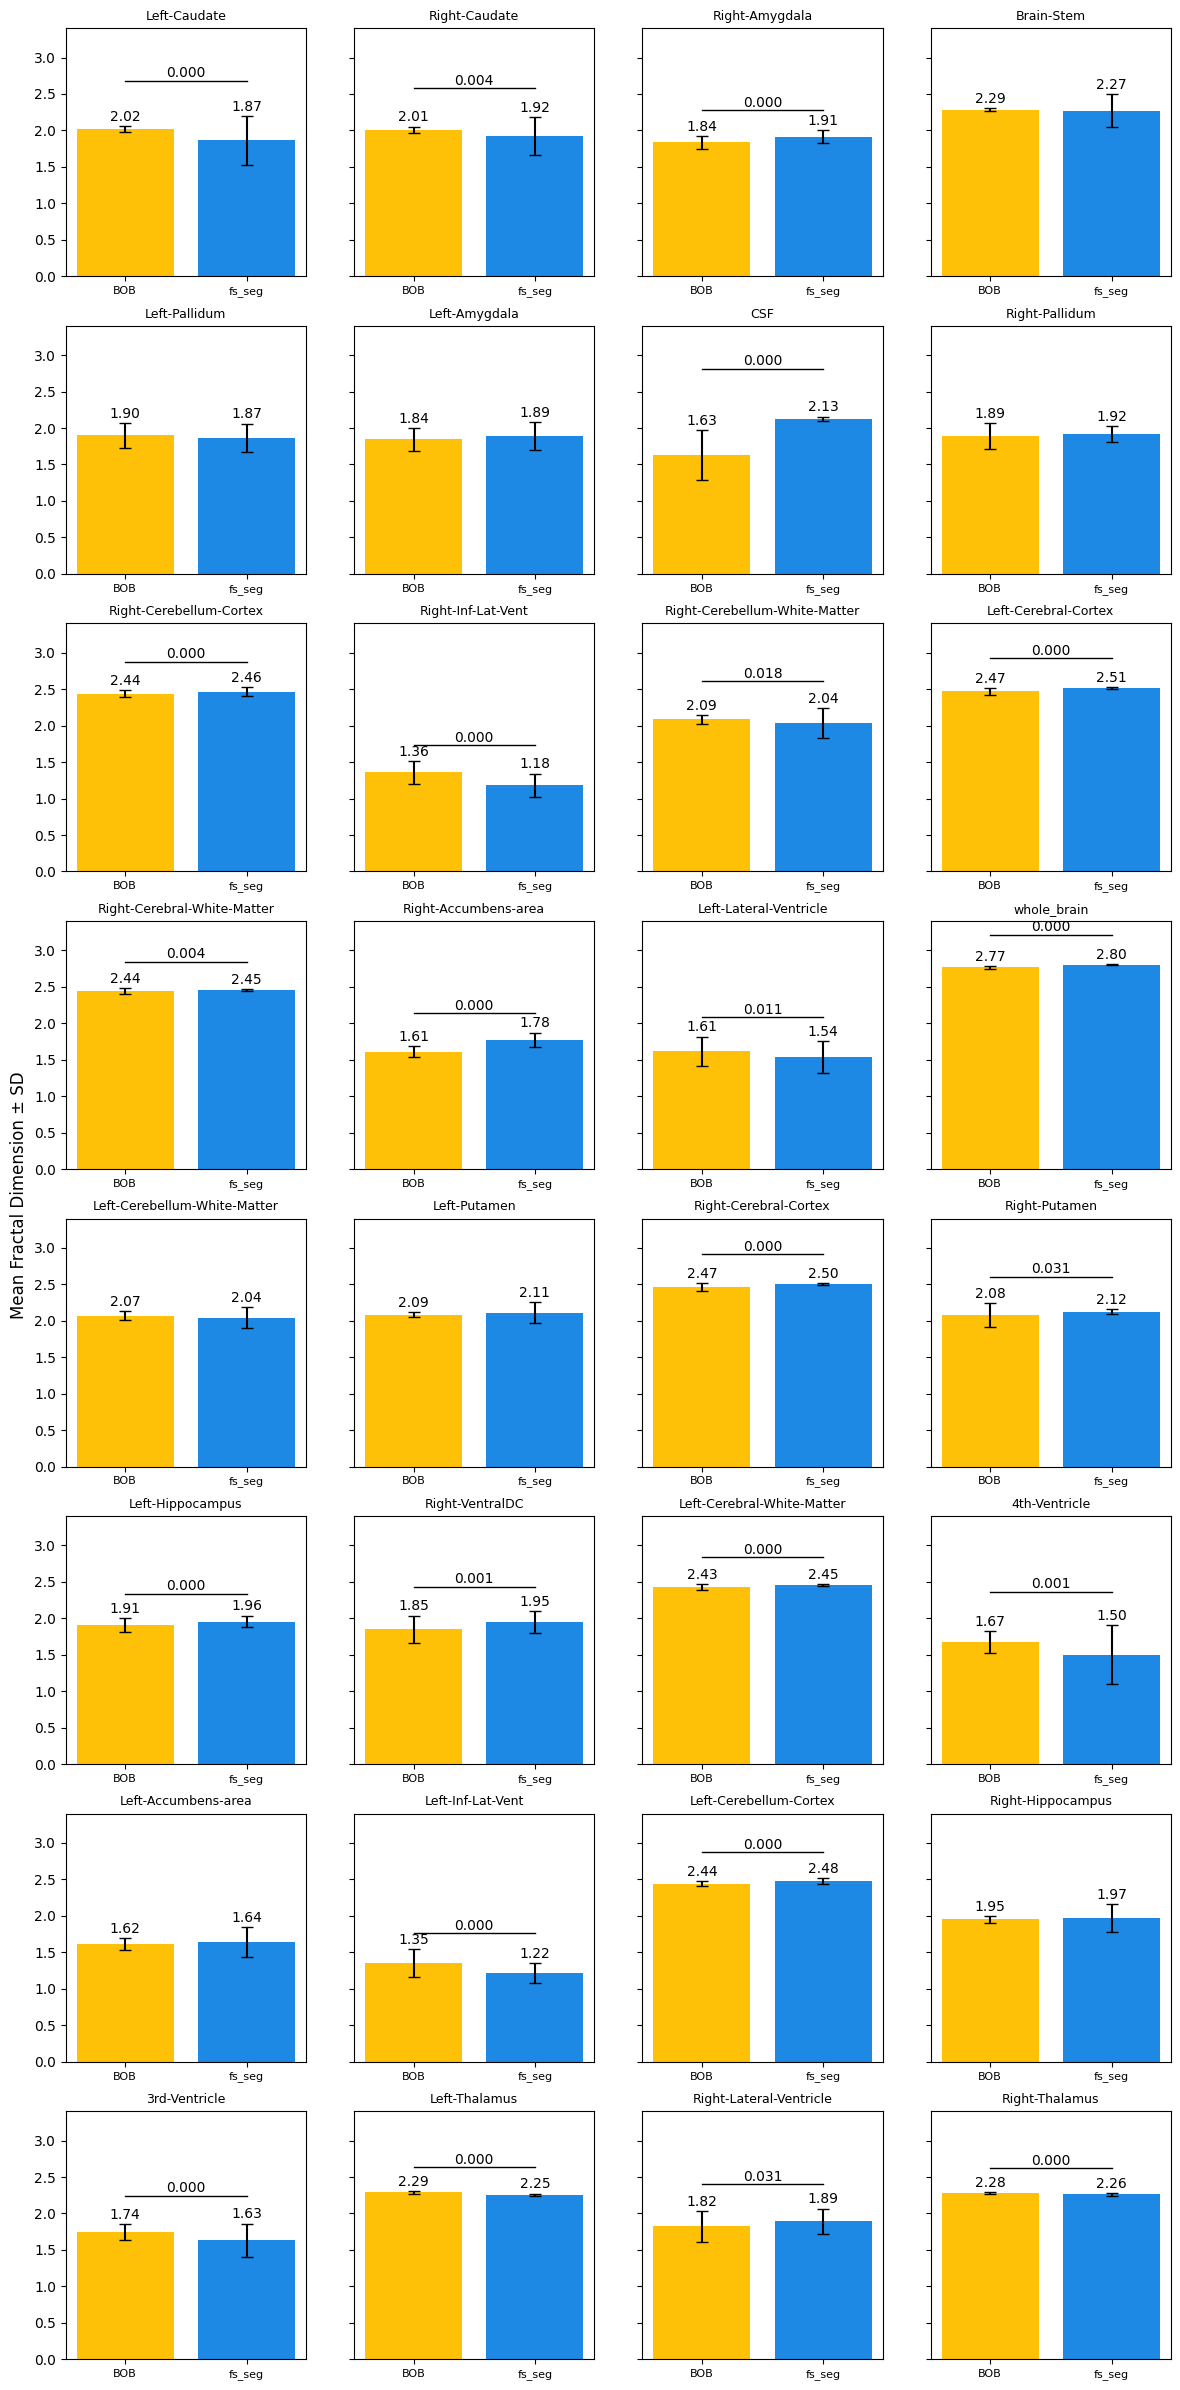

In [137]:
agg = df_merged.groupby('name')[['fd_BOB', 'fd_fs_seg']].agg(['mean', 'std'])

n_pairs = len(common_names)
ncols = 4
nrows = int(np.ceil(n_pairs / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3), sharey=True)
axes = axes.flatten()

for ax, label in zip(axes, common_names):
    means = agg.loc[label][('fd_BOB', 'mean')], agg.loc[label][('fd_fs_seg', 'mean')]
    stds  = agg.loc[label][('fd_BOB', 'std')],  agg.loc[label][('fd_fs_seg', 'std')]

    x = np.arange(2)
    ax.bar(x, means, yerr=stds, capsize=4, color=colors_seg)
    ax.set_xticks(x)
    ax.set_xticklabels(['BOB', 'fs_seg'], fontsize=8)
    ax.set_title(label, fontsize=9)

    # Annotate mean values
    for xi, m, sd in zip(x, means, stds):
        ax.text(xi, m + sd + 0.03, f"{m:.2f}", ha='center', va='bottom', fontsize=10)

        
    # Significance p-value
    p = float(df_stats[df_stats['name'] == label]['p-val'].iloc[0])
    if p < 0.05:
        y0 = (max(means) + max(stds))*1.14
        ax.plot([x[0], x[1]], [y0, y0], color='black', linewidth=1)
        ax.text((x[0]+x[1])/2, y0 + 0.005, f"{p:.3f}", ha='center', va='bottom', fontsize=10)


# Turn off empty subplots
for ax in axes[n_pairs:]:
    ax.axis('off')

fig.supylabel("Mean Fractal Dimension ± SD")
plt.setp(axes, ylim=(0, 3.4))
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

#### over age

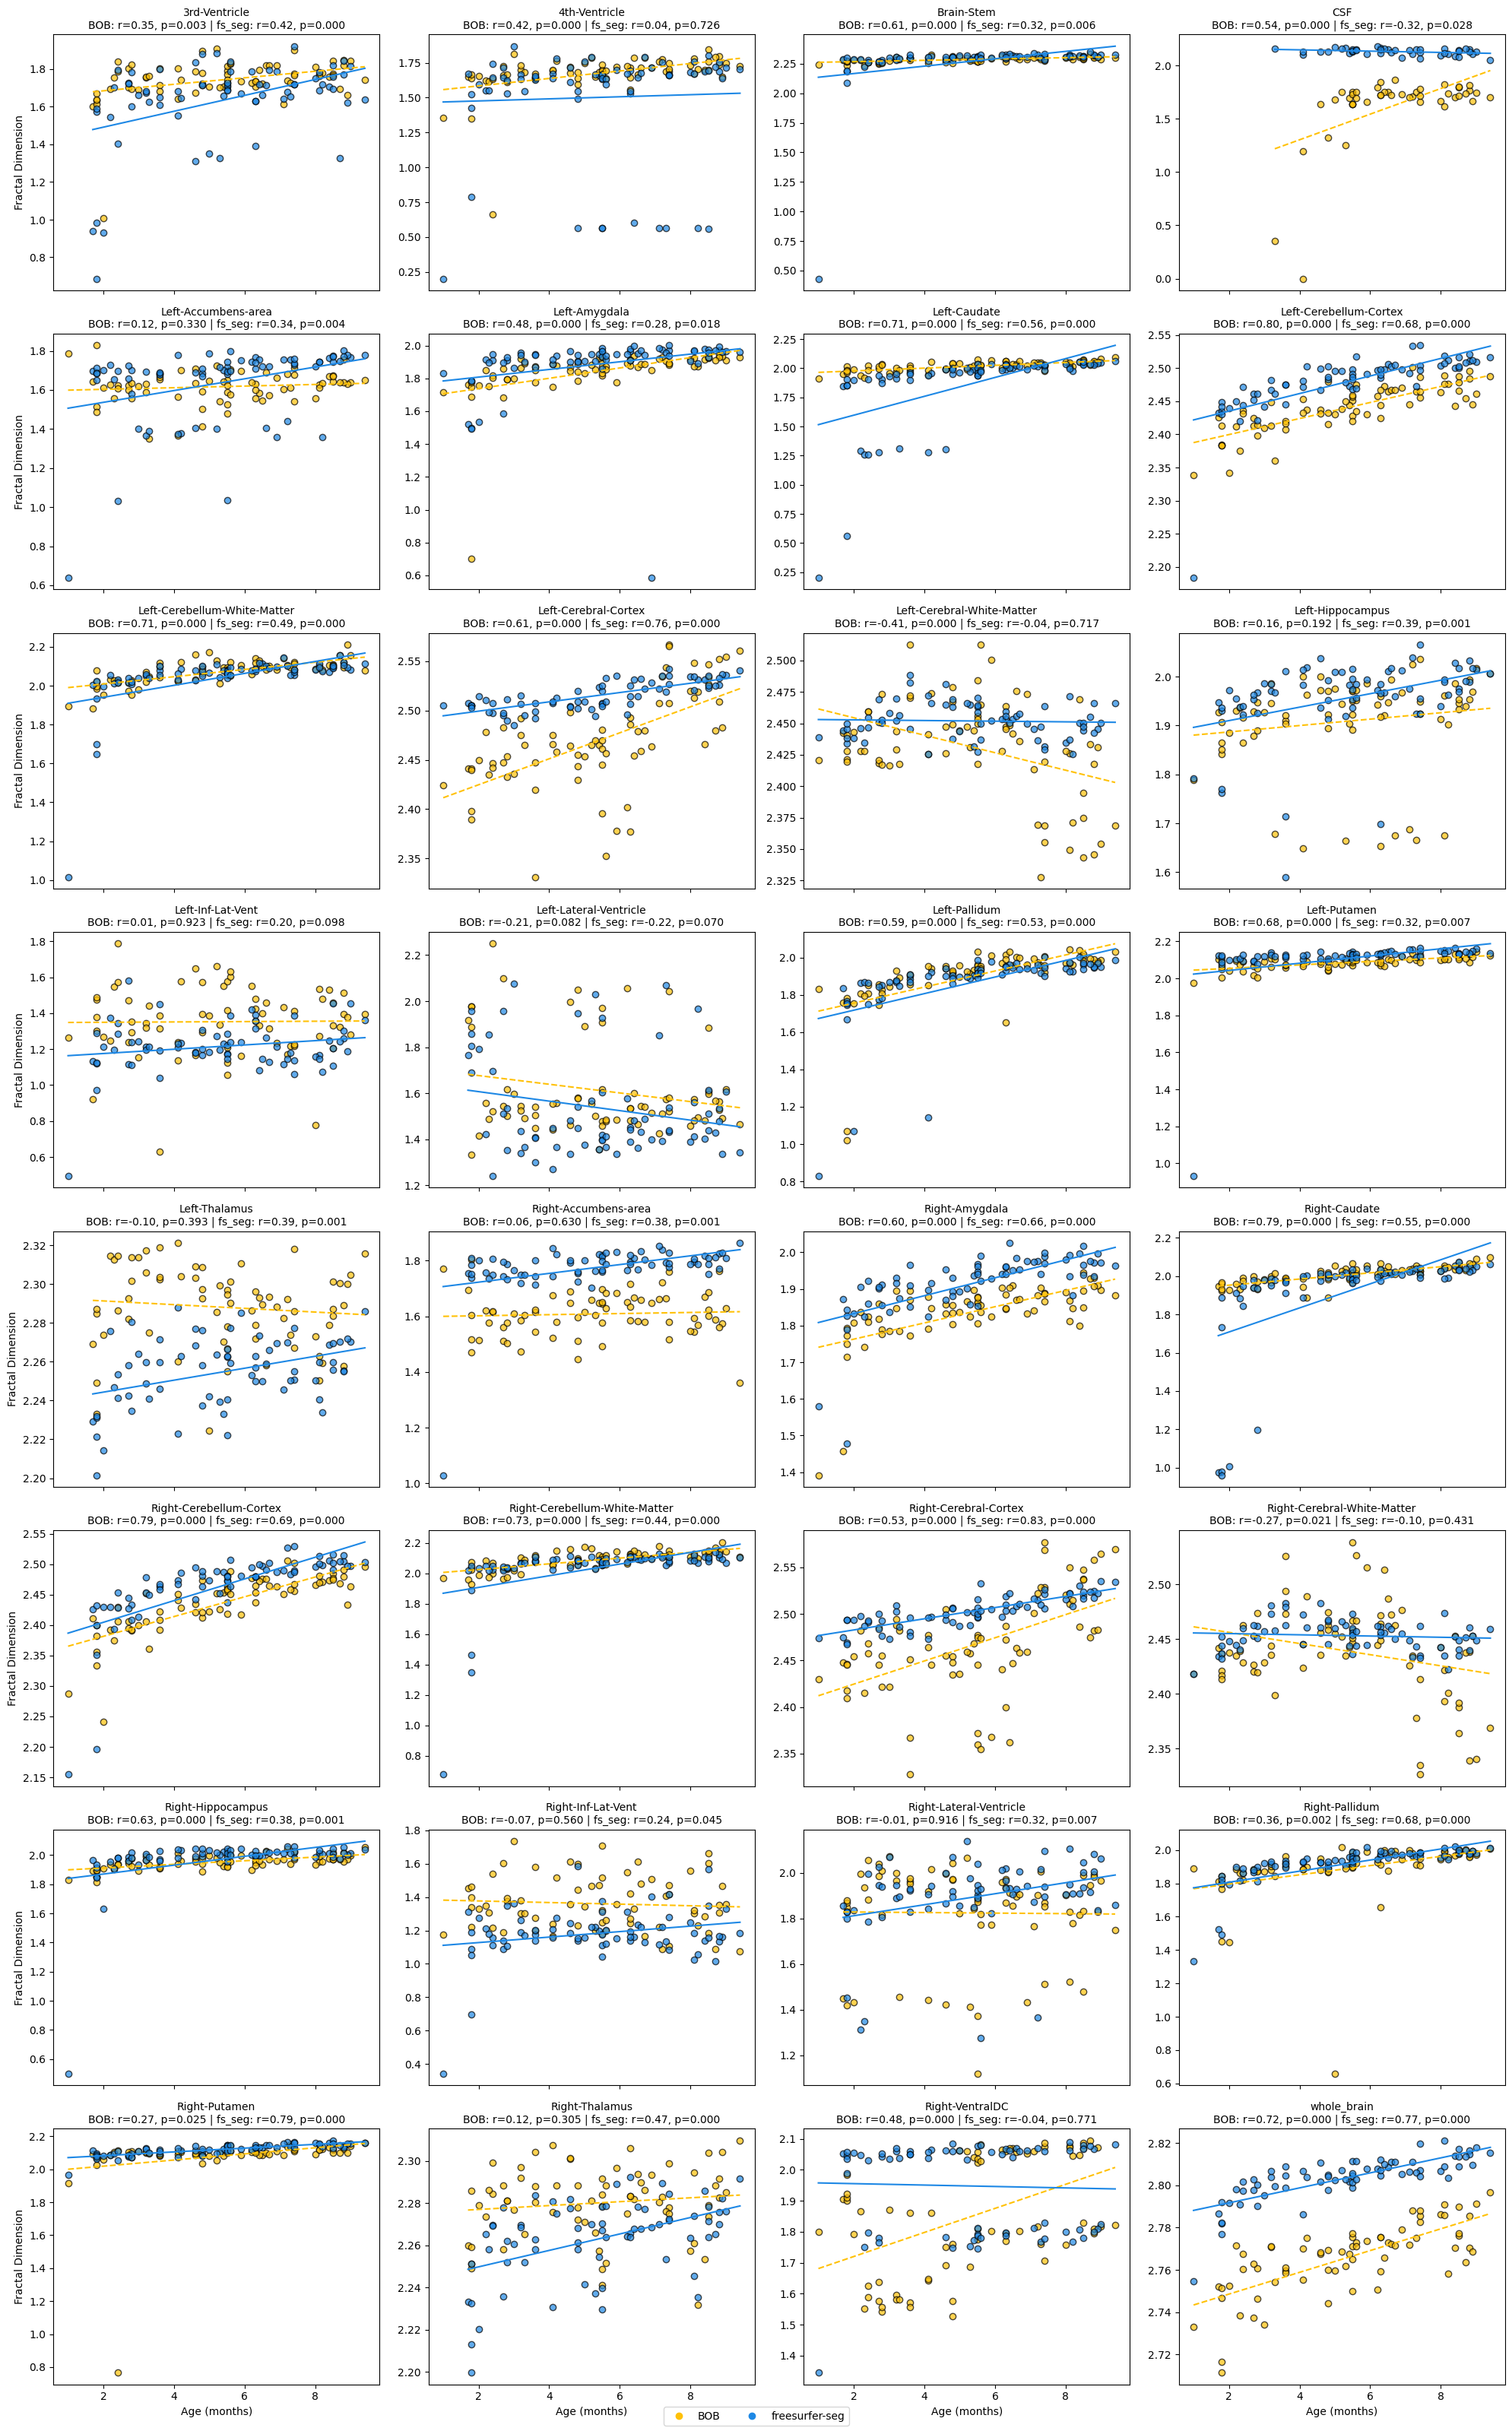

In [129]:
base_list = sorted(common_names)

n = len(base_list)
ncols = 4
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols * 5, nrows * 4),
                         sharex=True)
axes = axes.flatten()

for idx, base in enumerate(base_list):
    ax = axes[idx]
    
    sub = df_merged[df_merged['name'] == base]
    ages = sub['age'].values
    
    fds_BOB = sub['fd_BOB'].values
    fds_fs_seg = sub['fd_fs_seg'].values
    
    # Scatter plot for each method
    ax.scatter(ages, fds_BOB, label='BOB', color=colors_seg[0], edgecolor='k', alpha=0.7)
    ax.scatter(ages, fds_fs_seg, label='fs_seg', color=colors_seg[1], edgecolor='k', alpha=0.7)
    
    # Fit regression line for BOB
    if len(ages) > 1:
        slope_bob, intercept_bob = np.polyfit(ages, fds_BOB, 1)
        x_line = np.linspace(ages.min(), ages.max(), 100)
        y_line_bob = slope_bob * x_line + intercept_bob
        ax.plot(x_line, y_line_bob, color=colors_seg[0], linestyle='--')

    # Fit regression line for fs_seg
    if len(ages) > 1:
        slope_fs, intercept_fs = np.polyfit(ages, fds_fs_seg, 1)
        y_line_fs = slope_fs * x_line + intercept_fs
        ax.plot(x_line, y_line_fs, color=colors_seg[1], linestyle='-')
    
    # Pearson correlations
    r_bob, p_bob = pearsonr(ages, fds_BOB)
    r_fs, p_fs = pearsonr(ages, fds_fs_seg)

    ax.set_title(f"{base}\nBOB: r={r_bob:.2f}, p={p_bob:.3f} | fs_seg: r={r_fs:.2f}, p={p_fs:.3f}", fontsize=10)
    
    if idx // ncols == nrows - 1:
        ax.set_xlabel("Age (months)")
    if idx % ncols == 0:
        ax.set_ylabel("Fractal Dimension")

# Turn off unused axes
for j in range(n, len(axes)):
    axes[j].axis('off')

# Add legend once
handles = [plt.Line2D([], [], marker='o', linestyle='None', color=colors_seg[0], label='BOB'),
           plt.Line2D([], [], marker='o', linestyle='None', color=colors_seg[1], label='freesurfer-seg')]
fig.legend(handles=handles, loc='lower center', ncol=2)

plt.tight_layout()
plt.show()


#### statistical evaluation

let's evaluate the interaction of the following:


$$
FD = \beta_0 + \beta_1 \times \text{Age} + \beta_2 \times \text{Method} + \beta_3 \times (\text{Age} \times \text{Method}) + \epsilon
$$



In [130]:
df_fd_BOB['method'] = 'BOB'
df_fd_fs_seg['method'] = 'freesurfer-seg'
df_long = pd.concat([df_fd_BOB, df_fd_fs_seg], ignore_index=True)

In [ ]:
results = []

for base in sorted(df_long['name'].unique()):
    sub = df_long[df_long['name'] == base]
    
    if sub['method'].nunique() < 2:
        continue  # skip if only one method present
    
    # Fit linear model with interaction
    model = smf.ols('fd ~ age * method', data=sub).fit()
    
    # Extract the p-value for the interaction term
    p_interaction = model.pvalues['age:method[T.freesurfer-seg]']
    
    results.append({
        'name': base,
        'interaction_pval': round(p_interaction,3)
    })

df_interaction_stats = pd.DataFrame(results)
df_interaction_stats.sort_values('interaction_pval')


,name,interaction_pval
3,CSF,0.000
6,Left-Caudate,0.000
9,Left-Cerebral-Cortex,0.000
19,Right-Caudate,0.000
30,Right-VentralDC,0.001
10,Left-Cerebral-White-Matter,0.001
22,Right-Cerebral-Cortex,0.009
4,Left-Accumbens-area,0.018
2,Brain-Stem,0.022
31,whole_brain,0.023


In [136]:
#model.summary()